In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import itertools
import seaborn as sns

In [2]:
sfo_data = pd.read_csv('2017_SFO_Customer_Survey.csv')

I am going to predict whether someone is a business or non-business traveler. I will use 5-fold cross-validation. Precision-recall curves are appropriate for imbalanced data sets. I will predict whether someone is a business or non-business traveler using 'Transportation', 'Bags', 'Age', and 'Gender', because these have all been shown to have differences between business and non-business travelers and could be more easily discerned at an airport than 'Times Flown' or 'Income'. I have demonstrated that both 'Times Flown' and 'Income' are different between business and non-business travelers, but these are characteristics of the traveler that could not be known just by a person's behavior at the airport.

In [3]:
sfo_data = sfo_data.rename(columns={'Q2PURP1':'Purpose', 'Q3GETTO1':'Transportation', 'Q4BAGS':'Bags', 
                        'Q4STORE':'Store', 'Q4FOOD':'Food', 'Q4WIFI':'WiFi', 'Q5TIMESFLOWN':'Times Flown',
                        'Q11TSAPRE':'TSA Pre-Check', 'Q19AGE':'Age', 'Q20GENDER':'Gender', 'Q21INCOME':'Income'})

I have to figure out how to deal with sample weights. Can use sample_weights in .fit of Logistic Regression
I am going to drop the rows that have Blank/No Response for Purpose.

In [4]:
sfo_data['Purpose'] = sfo_data['Purpose'].map({1:'Business', 2:'Pleasure', 3:'Visit others', 4:'School', \
                                              5:'Conference', 6:'Life event', 7:'Other', \
                                               10:'Escorting/personal errands/medical', 11:'Military', \
                                              12:'Volunteer/political/religious', 13:'Moving/immigration', \
                                              0:'Blank/non-response'})

In [5]:
sfo_data['Bags'] = sfo_data['Bags'].map({1:'Yes', 2:'No', 3:"Don't know", 0:'Blank/multiple responses'})

In [6]:
sfo_data['Age'] = sfo_data['Age'].map({1:'Under18', 2:'18-24', 3:'25-34', 4:'35-44', 5:'45-54', 6:'55-64', \
                                            7:"65Over", 8:"Don't know/Refused", 0:'Blank/Multiple Responses'})

In [7]:
sfo_data['Transportation'] = sfo_data['Transportation'].map({1:'Drove and parked', 2:'Dropped off', \
                                                 3:'Connecting from another flight', 4:'Taxi', 5:'Uber/Lyft', 6:'BART', \
                                                 7:'Door-to-door van service', 8:'Free hotel shuttle', \
                                                 9:'Rental car center - AirTrain', \
                                                10:'Other', 11:'not used', 12:'Limo/town car', 13:'Airport bus', \
                                                14: 'Group arrangements', \
                                                 15: 'Bus', 16: 'Caltrain/Amtrak/Train', 17: 'VTA', 18:'Carshare', \
                                                 0:'Blank/no response'
                                                })

In [8]:
sfo_data['Gender'] = sfo_data['Gender'].map({1:'Male', 2:'Female', 3:'Other', 0:'Blank/Multiple responses'})

In [9]:
sfo_data['Times Flown'] = sfo_data['Times Flown'].map({1:'1', 2:'2', 3:'3-6', 4:'7-12', 5:'13-24', 6:'>24', \
                                                         0:'Blank/Multiple Responses'})

In [10]:
sfo_data['Income'] = sfo_data['Income'].map({1:'Under $50,000', 2:'$50,000 - $100,000', 3:'$100,000-$150,000', \
                                                  4:'Over $150,000', 5:'Other currency', \
                                                   0:'Blank/Multiple responses'})

In [11]:
sfo_data_2 = sfo_data[sfo_data['Purpose'] != 'Blank/non-response'] #drop all rows that did not specify purpose

In [12]:
#Making a new column that specifies whether the trip was business or non-business
sfo_data_2['Business?'] = sfo_data_2['Purpose'].apply(lambda x: 
                                            1 if x == 'Business'
                                            else 0)
sfo_data_2.head()

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,RESPNUM,CCGID,RUNID,INTDATE,DAY,GATE,BAREA,STRATA,PEAK,METHOD,...,Q22FLY,Q23SJC,Q23OAK,LANG,WEIGHT,Hi,HOWLONG,Q17CITY,Q17STATE,Business?
0,1,522,233,13,SAT,92,G,1,3,1,...,1,2,2,1,0.284718,NaN,210.0,MONTREAL,QC,0
1,2,504,237,13,SAT,75,F,2,3,1,...,2,2,2,1,0.944082,NaN,235.0,BERKELEY,CA,0
2,3,523,233,13,SAT,92,G,1,3,1,...,2,2,1,1,0.284718,NaN,60.0,RENO,NV,0
3,4,505,237,13,SAT,75,F,2,3,1,...,2,1,1,1,0.944082,NaN,175.0,SAN FRANCISCO,CA,0
4,5,524,233,13,SAT,92,G,1,3,1,...,1,2,2,1,0.284718,NaN,150.0,MONTREAL,QC,0


In [13]:
relevant_data = sfo_data_2[['Business?','Transportation','Bags','Age','Gender', 'WEIGHT']]
relevant_data.head()

,Business?,Transportation,Bags,Age,Gender,WEIGHT
0,0,Door-to-door van service,Yes,45-54,Female,0.284718
1,0,BART,No,25-34,Male,0.944082
2,0,Connecting from another flight,Blank/multiple responses,55-64,Female,0.284718
3,0,Rental car center - AirTrain,Yes,45-54,Female,0.944082
4,0,Uber/Lyft,Yes,35-44,Female,0.284718


In [14]:
X_sfodata = relevant_data[['Transportation','Bags','Age','Gender']]
y_sfodata = relevant_data['Business?']
weights_sfodata = relevant_data['WEIGHT']

In [15]:
#encoding to dummy variables
sfo_data_dummies = pd.get_dummies(X_sfodata, drop_first=True)
sfo_data_dummies.columns

Index(['Transportation_BART', 'Transportation_Blank/no response',
       'Transportation_Bus', 'Transportation_Connecting from another flight',
       'Transportation_Door-to-door van service', 'Transportation_Dropped off',
       'Transportation_Drove and parked', 'Transportation_Free hotel shuttle',
       'Transportation_Group arrangements', 'Transportation_Limo/town car',
       'Transportation_Other', 'Transportation_Rental car center - AirTrain',
       'Transportation_Taxi', 'Transportation_Uber/Lyft', 'Bags_Don't know',
       'Bags_No', 'Bags_Yes', 'Age_25-34', 'Age_35-44', 'Age_45-54',
       'Age_55-64', 'Age_65Over', 'Age_Blank/Multiple Responses',
       'Age_Don't know/Refused', 'Age_Under18', 'Gender_Female', 'Gender_Male',
       'Gender_Other'],
      dtype='object')

In [16]:
sfo_data_dummies.head()

,Transportation_BART,Transportation_Blank/no response,Transportation_Bus,Transportation_Connecting from another flight,Transportation_Door-to-door van service,Transportation_Dropped off,Transportation_Drove and parked,Transportation_Free hotel shuttle,Transportation_Group arrangements,Transportation_Limo/town car,...,Age_35-44,Age_45-54,Age_55-64,Age_65Over,Age_Blank/Multiple Responses,Age_Don't know/Refused,Age_Under18,Gender_Female,Gender_Male,Gender_Other
0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


Logistic regression, no balancing:

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

c_space = np.logspace(-5,8,15)
param_grid = {'C':c_space, 'penalty':['l1','l2']}

logreg = LogisticRegression()

X_train, X_test, y_train, y_test, sw_train, sw_test = \
train_test_split(sfo_data_dummies, y_sfodata, weights_sfodata, test_size=0.3, random_state=42)

logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc') #change scoring parameter
logreg_cv.fit(X_train,y_train,sample_weight=sw_train)

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                         'penalty': ['l1', 

In [18]:
logreg_cv.best_params_

{'C': 31.622776601683793, 'penalty': 'l2'}

In [19]:
logreg_cv.best_score_

0.7406773986954509

When predicting, should I use .predict or .predict_proba? What about log loss? What about imbalance of data set (this is not super severe, but is about 2/3-1/3. What does best_score_ represent? https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/ How does it know which class is positive and which one is negative? How to improve when I have huge number of false negatives (algorithm not sensitive enough).

In [20]:
pred_logreg = logreg_cv.predict(X_test)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_logreg, sample_weight = sw_test)

0.7533741064485217

In [22]:
from sklearn.metrics import f1_score
f1_score(y_test, pred_logreg, sample_weight = sw_test, pos_label=1)

0.4502896701329843

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_logreg, sample_weight = sw_test))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84 590.7823883480975
           1       0.62      0.35      0.45 235.43609448800012

    accuracy                           0.75 826.2184828360976
   macro avg       0.70      0.63      0.65 826.2184828360976
weighted avg       0.73      0.75      0.73 826.2184828360976



Logistic regression with balanced class weights:

In [24]:
c_space = np.logspace(-5,8,15)
param_grid_2 = {'C':c_space, 'penalty':['l1','l2']}

logreg2 = LogisticRegression(class_weight='balanced')

logreg_cv_2 = GridSearchCV(logreg2, param_grid_2, cv=5, scoring='roc_auc')
logreg_cv_2.fit(X_train,y_train,sample_weight=sw_train)

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                         'penalty': [

In [25]:
logreg_cv_2.best_params_

{'C': 31.622776601683793, 'penalty': 'l2'}

In [26]:
logreg_cv_2.best_score_

0.7408098626275847

In [27]:
pred_logreg_2 = logreg_cv_2.predict(X_test)

In [28]:
accuracy_score(y_test, pred_logreg_2, sample_weight = sw_test)

0.6451722147886684

In [29]:
f1_score(y_test, pred_logreg_2, sample_weight = sw_test, pos_label=1)

0.5387304194195163

In [30]:
print(classification_report(y_test, pred_logreg_2, sample_weight = sw_test))

              precision    recall  f1-score   support

           0       0.85      0.61      0.71 590.7823883480975
           1       0.43      0.73      0.54 235.43609448800012

    accuracy                           0.65 826.2184828360976
   macro avg       0.64      0.67      0.63 826.2184828360976
weighted avg       0.73      0.65      0.66 826.2184828360976



Now I will try working with a decision tree.

In [31]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(class_weight='balanced', max_depth=3)
dtree.fit(X_train,y_train,sample_weight=sw_train.values)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


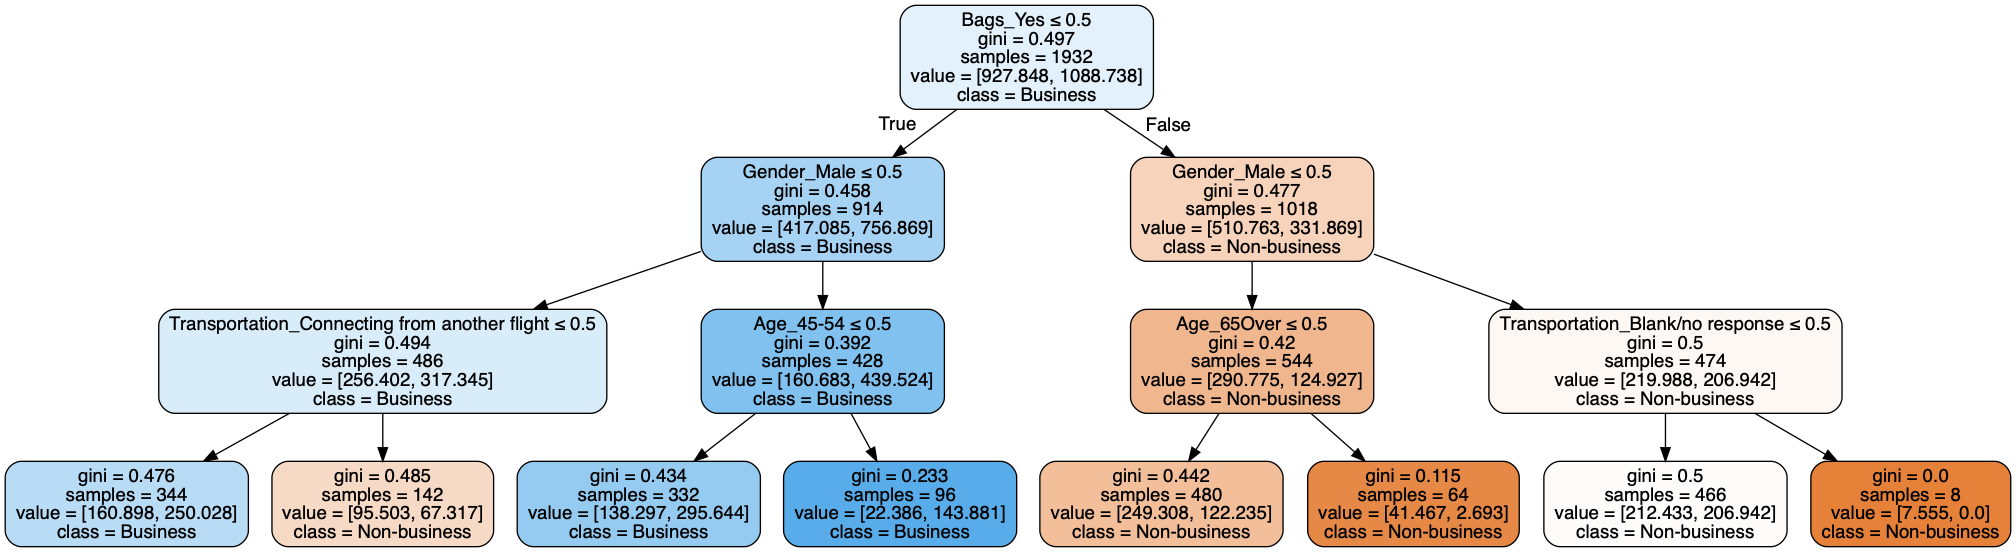

In [32]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_train.columns, class_names=['Non-business', 'Business'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Bags seems to be biggest predictor - no bags, male, ages 45-54 are business with lowest Gini impurity. Bags, female, ages 65 and over are female with lowest Gini impurity.

Random Forest with balanced classes

In [33]:
from sklearn.ensemble import RandomForestClassifier
param_grid_rfc = { 
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['auto', 'sqrt', 'log2']
}

rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
rfc_cv = GridSearchCV(rfc, param_grid_rfc, cv=5, scoring='roc_auc')
rfc_cv.fit(X_train,y_train,sample_weight=sw_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
            

In [34]:
rfc_cv.best_params_

{'max_features': 'auto', 'n_estimators': 1000}

In [35]:
rfc_cv.best_score_

0.6943954939336474

In [36]:
pred_rfc = rfc_cv.predict(X_test)

In [37]:
accuracy_score(y_test, pred_rfc, sample_weight = sw_test)

0.6392444288689101

In [38]:
f1_score(y_test, pred_rfc, sample_weight = sw_test, pos_label=1)

0.4829690426001205

In [39]:
print(classification_report(y_test, pred_rfc, sample_weight = sw_test))

              precision    recall  f1-score   support

           0       0.80      0.66      0.72 590.7823883480975
           1       0.41      0.59      0.48 235.43609448800012

    accuracy                           0.64 826.2184828360976
   macro avg       0.60      0.62      0.60 826.2184828360976
weighted avg       0.69      0.64      0.65 826.2184828360976



Random forest without balanced classes

In [40]:
from sklearn.ensemble import RandomForestClassifier
param_grid_rfc_2 = { 
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['auto', 'sqrt', 'log2']
}

rfc_2 = RandomForestClassifier(random_state=42)
rfc_cv_2 = GridSearchCV(rfc_2, param_grid_rfc_2, cv=5, scoring='roc_auc')
rfc_cv_2.fit(X_train,y_train,sample_weight=sw_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [41]:
rfc_cv_2.best_params_

{'max_features': 'auto', 'n_estimators': 1800}

In [42]:
rfc_cv_2.best_score_

0.6983624168105703

In [43]:
pred_rfc_2 = rfc_cv_2.predict(X_test)

In [44]:
accuracy_score(y_test, pred_rfc_2, sample_weight = sw_test)

0.7246222941491199

In [45]:
f1_score(y_test, pred_rfc_2, sample_weight = sw_test, pos_label=1)

0.4404518530459116

In [46]:
print(classification_report(y_test, pred_rfc_2, sample_weight = sw_test))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82 590.7823883480975
           1       0.52      0.38      0.44 235.43609448800012

    accuracy                           0.72 826.2184828360976
   macro avg       0.65      0.62      0.63 826.2184828360976
weighted avg       0.70      0.72      0.71 826.2184828360976



Going to try oversampling.

In [47]:
from sklearn.utils import resample

# concatenate our training data back together
X_resample = pd.concat([X_train, y_train, sw_train], axis=1)

# separate minority and majority classes
not_business = X_resample[X_resample['Business?']==0]
business = X_resample[X_resample['Business?']==1]

# upsample minority
business_upsampled = resample(business,
                          replace=True, # sample with replacement
                          n_samples=len(not_business), # match number in majority class
                          random_state=42) # reproducible results

upsampled = pd.concat([not_business, business_upsampled])
upsampled.head()

,Transportation_BART,Transportation_Blank/no response,Transportation_Bus,Transportation_Connecting from another flight,Transportation_Door-to-door van service,Transportation_Dropped off,Transportation_Drove and parked,Transportation_Free hotel shuttle,Transportation_Group arrangements,Transportation_Limo/town car,...,Age_55-64,Age_65Over,Age_Blank/Multiple Responses,Age_Don't know/Refused,Age_Under18,Gender_Female,Gender_Male,Gender_Other,Business?,WEIGHT
1831,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.723116
2237,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0.723116
361,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.632960
685,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.115649
1349,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.944082


In [48]:
X_train_upsampled = upsampled.drop('Business?', axis=1)
X_train_upsampled = X_train_upsampled.drop('WEIGHT', axis=1)
X_train_upsampled.head()

,Transportation_BART,Transportation_Blank/no response,Transportation_Bus,Transportation_Connecting from another flight,Transportation_Door-to-door van service,Transportation_Dropped off,Transportation_Drove and parked,Transportation_Free hotel shuttle,Transportation_Group arrangements,Transportation_Limo/town car,...,Age_35-44,Age_45-54,Age_55-64,Age_65Over,Age_Blank/Multiple Responses,Age_Don't know/Refused,Age_Under18,Gender_Female,Gender_Male,Gender_Other
1831,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2237,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
361,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
685,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1349,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [49]:
y_train_upsampled = upsampled['Business?']
sw_train_upsampled = upsampled['WEIGHT']

In [50]:
param_grid_rfc_3 = { 
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['auto', 'sqrt', 'log2']
}

rfc_3 = RandomForestClassifier(random_state=42)
rfc_cv_3 = GridSearchCV(rfc_3, param_grid_rfc_3, cv=5, scoring='roc_auc')
rfc_cv_3.fit(X_train_upsampled,y_train_upsampled,sample_weight=sw_train_upsampled)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [51]:
rfc_cv_3.best_params_

{'max_features': 'log2', 'n_estimators': 600}

In [52]:
rfc_cv_3.best_score_

0.8000687758028557

In [53]:
pred_rfc_3 = rfc_cv_3.predict(X_test)

In [54]:
accuracy_score(y_test, pred_rfc_3, sample_weight = sw_test)

0.6120345118698012

In [55]:
f1_score(y_test, pred_rfc_3, sample_weight = sw_test, pos_label=1)

0.46986523728409585

In [56]:
print(classification_report(y_test, pred_rfc_3, sample_weight = sw_test))

              precision    recall  f1-score   support

           0       0.80      0.62      0.69 590.7823883480975
           1       0.38      0.60      0.47 235.43609448800012

    accuracy                           0.61 826.2184828360976
   macro avg       0.59      0.61      0.58 826.2184828360976
weighted avg       0.68      0.61      0.63 826.2184828360976



Logistic regression with upsampling

In [57]:
param_grid_3 = {'C':c_space, 'penalty':['l1','l2']}

logreg3 = LogisticRegression()

logreg_cv_3 = GridSearchCV(logreg3, param_grid_3, cv=5, scoring='roc_auc')
logreg_cv_3.fit(X_train_upsampled,y_train_upsampled,sample_weight=sw_train_upsampled)

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                         'penalty': ['l1', 

In [58]:
logreg_cv_3.best_params_

{'C': 31.622776601683793, 'penalty': 'l1'}

In [59]:
logreg_cv_3.best_score_

0.741011682776533

In [60]:
pred_logreg_3 = logreg_cv_3.predict(X_test)

In [61]:
pred_logreg_3_proba = logreg_cv_3.predict_proba(X_test)

In [62]:
pred_logreg_3_proba.shape

(828, 2)

In [63]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, pred_logreg_3_proba[:,1], sample_weight=sw_test.values)
thresholds = np.append(thresholds, 1)

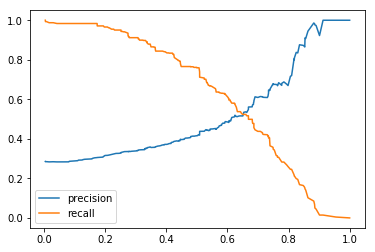

In [64]:
plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
plt.legend(('precision', 'recall'))
plt.show()

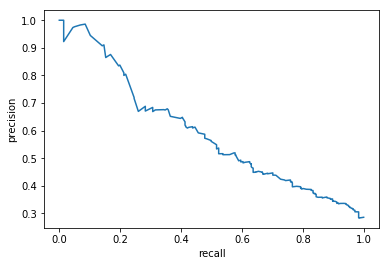

In [65]:
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [66]:
accuracy_score(y_test, pred_logreg_3, sample_weight = sw_test)

0.6267293062112735

In [67]:
f1_score(y_test, pred_logreg_3, sample_weight = sw_test, pos_label=1)

0.536936184873842

In [68]:
recall_score(y_test, pred_logreg_3, sample_weight = sw_test, pos_label=1)

0.7594472023588266

In [69]:
print(classification_report(y_test, pred_logreg_3, sample_weight = sw_test))

              precision    recall  f1-score   support

           0       0.86      0.57      0.69 590.7823883480975
           1       0.42      0.76      0.54 235.43609448800012

    accuracy                           0.63 826.2184828360976
   macro avg       0.64      0.67      0.61 826.2184828360976
weighted avg       0.73      0.63      0.64 826.2184828360976



SVM with balanced classes, no upsampling

In [70]:
from sklearn import svm

svc_1 = svm.SVC(class_weight = 'balanced')

Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['linear', 'rbf', 'poly']
param_grid_svm = {'C': Cs, 'gamma' : gammas, 'kernel': kernels}
svc_1_cv = GridSearchCV(svc_1, param_grid_svm, cv=5, scoring='roc_auc')
svc_1_cv.fit(X_train,y_train,sample_weight=sw_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [71]:
svc_1_cv.best_params_

{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

In [72]:
pred_svc_1 = svc_1_cv.predict(X_test)

In [73]:
f1_score(y_test, pred_svc_1, sample_weight = sw_test, pos_label=1)

0.5177737224600525

In [74]:
recall_score(y_test, pred_svc_1, sample_weight = sw_test, pos_label=1)

0.7000919936246269

In [75]:
print(classification_report(y_test, pred_svc_1, sample_weight = sw_test))

              precision    recall  f1-score   support

           0       0.83      0.60      0.70 590.7823883480975
           1       0.41      0.70      0.52 235.43609448800012

    accuracy                           0.63 826.2184828360976
   macro avg       0.62      0.65      0.61 826.2184828360976
weighted avg       0.71      0.63      0.65 826.2184828360976



SVM with upsampling

In [76]:
svc_2 = svm.SVC()
svc_2_cv = GridSearchCV(svc_2, param_grid_svm, cv=5, scoring='roc_auc')
svc_2_cv.fit(X_train_upsampled,y_train_upsampled,sample_weight=sw_train_upsampled)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [77]:
svc_2_cv.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

In [78]:
pred_svc_2 = svc_2_cv.predict(X_test)

In [79]:
f1_score(y_test, pred_svc_2, sample_weight = sw_test, pos_label=1)

0.5169825568705837

In [80]:
recall_score(y_test, pred_svc_2, sample_weight = sw_test, pos_label=1)

0.6919954756223833

In [81]:
print(classification_report(y_test, pred_svc_1, sample_weight = sw_test))

              precision    recall  f1-score   support

           0       0.83      0.60      0.70 590.7823883480975
           1       0.41      0.70      0.52 235.43609448800012

    accuracy                           0.63 826.2184828360976
   macro avg       0.62      0.65      0.61 826.2184828360976
weighted avg       0.71      0.63      0.65 826.2184828360976



Using income and # of times flown as predictors as well:

In [82]:
relevant_data_2 = sfo_data_2[['Business?','Transportation','Bags','Age','Gender','Income','Times Flown','WEIGHT']]
X_sfodata_more = relevant_data_2[['Transportation','Bags','Age','Gender','Income','Times Flown']]
y_sfodata_more = relevant_data_2['Business?']
weights_sfodata_more = relevant_data_2['WEIGHT']
#encoding to dummy variables
sfo_data_dummies_more = pd.get_dummies(X_sfodata_more, drop_first=True)
sfo_data_dummies_more.columns

Index(['Transportation_BART', 'Transportation_Blank/no response',
       'Transportation_Bus', 'Transportation_Connecting from another flight',
       'Transportation_Door-to-door van service', 'Transportation_Dropped off',
       'Transportation_Drove and parked', 'Transportation_Free hotel shuttle',
       'Transportation_Group arrangements', 'Transportation_Limo/town car',
       'Transportation_Other', 'Transportation_Rental car center - AirTrain',
       'Transportation_Taxi', 'Transportation_Uber/Lyft', 'Bags_Don't know',
       'Bags_No', 'Bags_Yes', 'Age_25-34', 'Age_35-44', 'Age_45-54',
       'Age_55-64', 'Age_65Over', 'Age_Blank/Multiple Responses',
       'Age_Don't know/Refused', 'Age_Under18', 'Gender_Female', 'Gender_Male',
       'Gender_Other', 'Income_$50,000 - $100,000',
       'Income_Blank/Multiple responses', 'Income_Over $150,000',
       'Income_Under $50,000', 'Times Flown_13-24', 'Times Flown_2',
       'Times Flown_3-6', 'Times Flown_7-12', 'Times Flown_>24',

In [83]:
X_train_2, X_test_2, y_train_2, y_test_2, sw_train_2, sw_test_2 = \
train_test_split(sfo_data_dummies_more, y_sfodata_more, weights_sfodata_more, test_size=0.3, random_state=41)

In [84]:
from sklearn.tree import DecisionTreeClassifier
dtree2=DecisionTreeClassifier(class_weight='balanced', max_depth=3)
dtree2.fit(X_train_2,y_train_2,sample_weight=sw_train_2.values)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

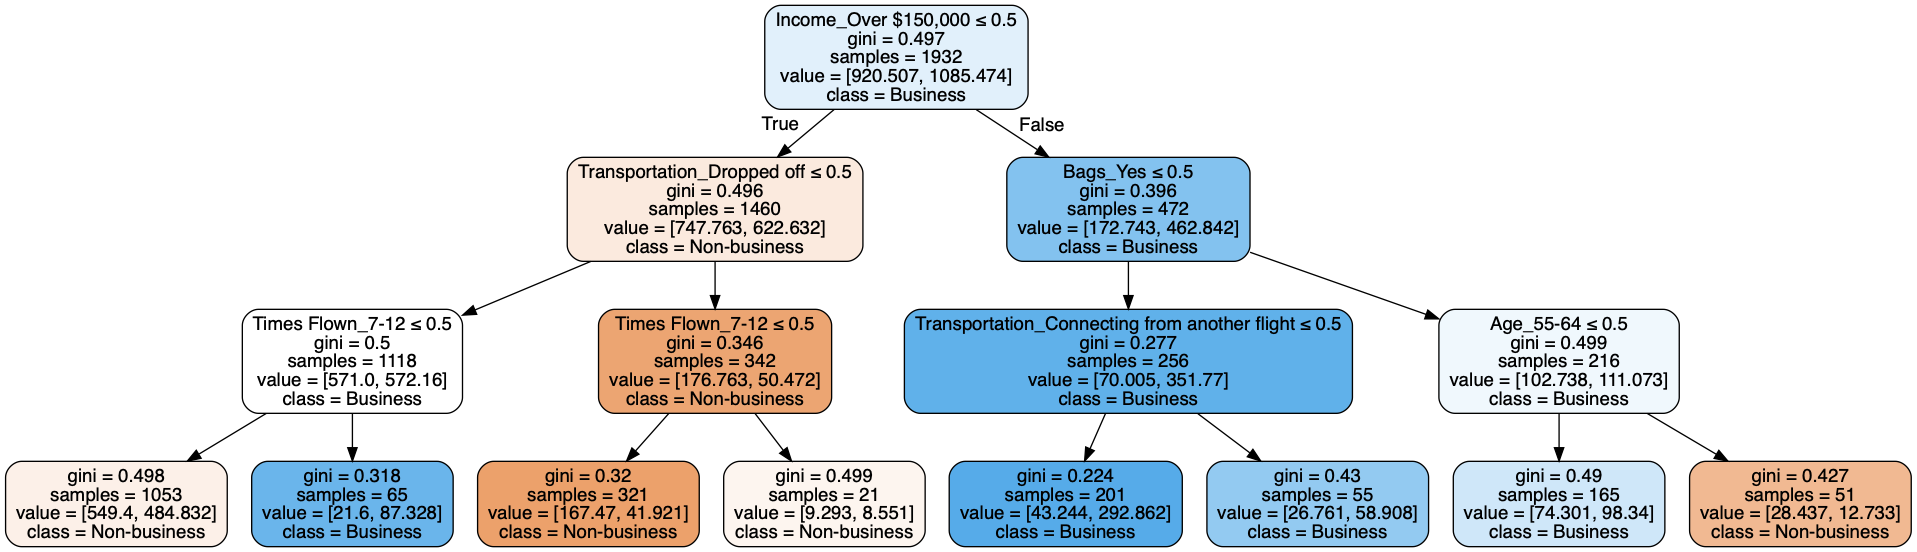

In [85]:
dot_data = StringIO()
export_graphviz(dtree2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_train_2.columns, class_names=['Non-business', 'Business'])
graph_2 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph_2.create_png())

Logistic regression with class balancing

In [86]:
c_space = np.logspace(-5,8,15)
param_grid = {'C':c_space, 'penalty':['l1','l2']}

logreg_more = LogisticRegression(class_weight='balanced')

logreg_cv_more = GridSearchCV(logreg_more, param_grid, cv=5, scoring='roc_auc')
logreg_cv_more.fit(X_train_2,y_train_2,sample_weight=sw_train_2)

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/melaniemalinas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                         'penalty': [

In [87]:
logreg_cv_more.best_params_

{'C': 0.4393970560760795, 'penalty': 'l2'}

In [88]:
pred_logreg_more = logreg_cv_more.predict(X_test_2)

In [89]:
f1_score(y_test_2, pred_logreg_more, sample_weight = sw_test_2, pos_label=1)

0.6003230630987966

In [90]:
print(classification_report(y_test_2, pred_logreg_more, sample_weight = sw_test_2))

              precision    recall  f1-score   support

           0       0.87      0.70      0.78 595.8865187451983
           1       0.50      0.74      0.60 243.89491026380017

    accuracy                           0.71 839.7814290089984
   macro avg       0.69      0.72      0.69 839.7814290089984
weighted avg       0.76      0.71      0.73 839.7814290089984

